Source: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [269]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_regression
from collections import defaultdict
import missingno as msno


In [270]:
state_list = ['Alabama',
'Alaska',
'Arizona',
'Arkansas',
'California',
'Colorado',
'Connecticut',
'Delaware',
'Florida',
'Georgia',
'Hawaii',
'Idaho',
'Illinois',
'Indiana',
'Iowa',
'Kansas',
'Kentucky',
'Louisiana',
'Maine',
'Maryland',
'Massachusetts',
'Michigan',
'Minnesota',
'Mississippi',
'Missouri',
'Montana', 
'Nebraska',
'Nevada',
'New Hampshire',
'New Jersey',
'New Mexico',
'New York',
'North Carolina',
'North Dakota',
'Ohio',
'Oklahoma',
'Oregon',
'Pennsylvania',
'Rhode Island',
'South Carolina',
'South Dakota',
'Tennessee',
'Texas',
'Utah',
'Vermont',
'Virginia',
'Washington',
'West Virginia',
'Wisconsin',
'Wyoming', 'District of Columbia', 'United States']

In [271]:
df = pd.read_csv('Data/county_data_clean.csv').drop(columns='Unnamed: 0')

df = df[~(df.name.apply(lambda x: x in state_list))]
df['5_digit_fips_code'] = df['5_digit_fips_code'].apply(lambda x: str(x))

In [272]:
non_normalized_columns = []

for column in df.columns:
    if column not in ['state_fips_code','county_fips_code','5_digit_fips_code', 'state_abbreviation','name']:
        if (df[column].values > 1.0).any():
            non_normalized_columns.append(column)


non_normalized_columns

['premature_death',
 'premature_death_black',
 'premature_death_hispanic',
 'premature_death_white',
 'poor_physical_health_days',
 'poor_mental_health_days',
 'food_environment_index',
 'sexually_transmitted_infections',
 'teen_births',
 'teen_births_black',
 'teen_births_hispanic',
 'teen_births_white',
 'ratio_of_population_to_primary_care_physicians',
 'ratio_of_population_to_dentists',
 'ratio_of_population_to_mental_health_providers',
 'preventable_hospital_stays',
 'preventable_hospital_stays_black',
 'preventable_hospital_stays_hispanic',
 'preventable_hospital_stays_white',
 'income_inequality',
 'social_associations',
 'violent_crime',
 'injury_deaths',
 'air_pollution__particulate_matter',
 'life_expectancy',
 'life_expectancy_black',
 'life_expectancy_hispanic',
 'life_expectancy_white',
 'premature_age_adjusted_mortality',
 'premature_age_adjusted_mortality_black',
 'premature_age_adjusted_mortality_hispanic',
 'premature_age_adjusted_mortality_white',
 'child_mortality',


In [273]:
features_df = df.drop(['uninsured_adults', 'uninsured_children', 'county_fips_code',
                   '5_digit_fips_code'], axis = 1)
# Replacing missing value of uninsured with mean of uninsured
features_df['uninsured'] = features_df.uninsured.replace([float("nan")], features_df.uninsured.mean())

for column in features_df.columns:
    na_sum= (features_df[column].isna().sum())
    column_size = (features_df[column].size)
    if (features_df[column].isna().sum()/features_df[column].size) > 0.25:
        features_df = features_df.drop(columns=column)
features_df.shape

(3141, 77)

In [274]:
state_groupby = features_df.groupby('state_abbreviation').count()

In [275]:
state_groupby = features_df.groupby('state_abbreviation').count()
null_count_dict = defaultdict(int)

for column in state_groupby.columns:
    null_count_dict[column] = 0
    for state in state_groupby.index:
        value = state_groupby.loc[state][column]
        size = state_groupby.loc[state]['state_fips_code']
        if (value/size) <= 0.25:
            print("{0} is not useful for {1}: {2}".format(column, state, str(value/size)))
            null_count_dict[column] += 1
            
exclude_features = []
for feature, null_count in null_count_dict.items():
    if null_count > 13:
        exclude_features.append(feature.strip(""))

high_school_graduation is not useful for ND: 0.24528301886792453
air_pollution__particulate_matter is not useful for AK: 0.0
air_pollution__particulate_matter is not useful for HI: 0.0
drinking_water_violations is not useful for HI: 0.0
hiv_prevalence is not useful for ND: 0.22641509433962265
hiv_prevalence is not useful for NE: 0.12903225806451613
hiv_prevalence is not useful for SD: 0.0
motor_vehicle_crash_deaths is not useful for AK: 0.2413793103448276
children_eligible_for_free_or_reduced_price_lunch is not useful for DE: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for MA: 0.0
children_eligible_for_free_or_reduced_price_lunch is not useful for TN: 0.0


In [276]:
features_df = features_df.drop(columns = exclude_features)

In [277]:
# Drop indices that has more than 25% data
exclude_indices = []
for index in features_df.index:
    series = features_df.drop(columns=['state_fips_code', 'state_abbreviation', 'name']).loc[index]
    null_count = len(series[series.isnull()])
    series_size = len(series)
    if (null_count/series_size) >= 0.25:
        exclude_indices.append(index)

features_df = features_df.drop(index=exclude_indices)

<AxesSubplot:>

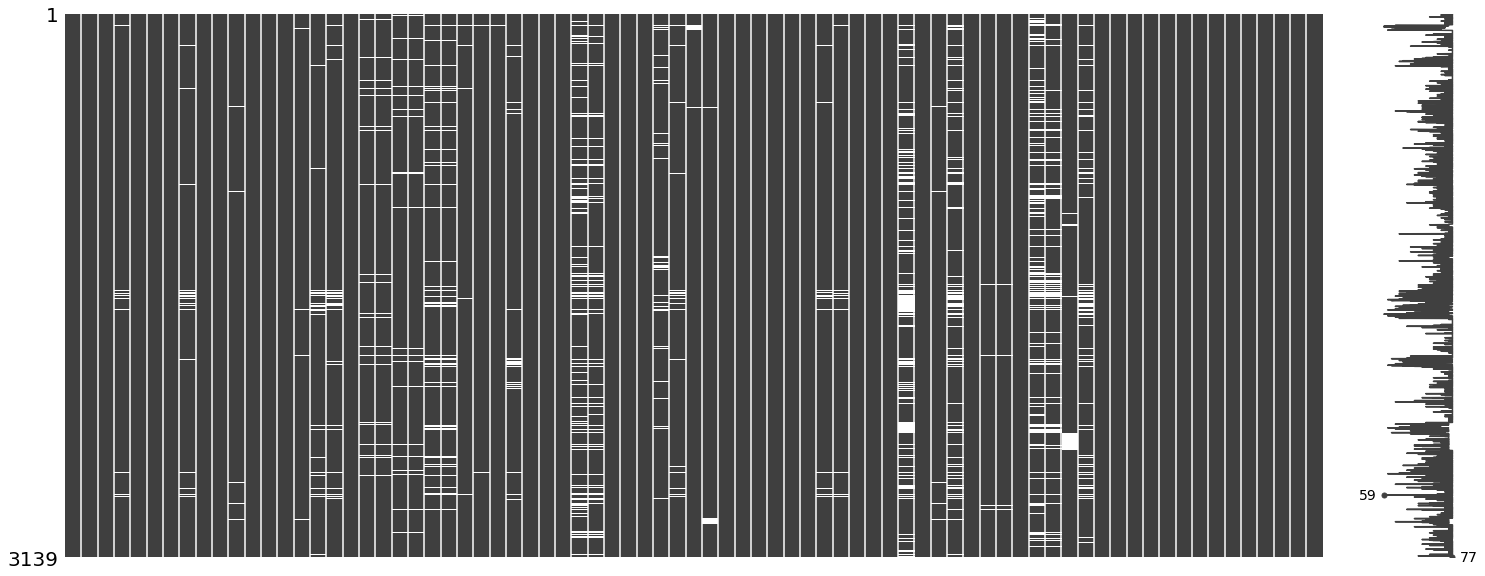

In [278]:
# Illustrate missing data
msno.matrix(features_df)

In [279]:
features = features_df.drop(['uninsured','state_fips_code','state_abbreviation', 'name'], axis = 1)
features_list = features_df.drop(['uninsured','state_fips_code', 'state_abbreviation'], axis = 1).columns.to_list()
imp = SimpleImputer()
features = imp.fit_transform(features)

labels = np.array(features_df['uninsured'])





In [281]:
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.20, random_state = 42, stratify=features_df.state_abbreviation)


In [282]:
# Random forest regressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [283]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'percent.')

Mean Absolute Error: 0.02 percent.


In [284]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 82.32 %.


In [285]:
name = features[:, features_list.index('name')]
test_name = test_features[:, features_list.index('name')]


# Dataframe with true values
true_data = pd.DataFrame(data = {'county_name': test_name, 'actual': test_labels})
true_data.actual = true_data.actual.apply(lambda x: x * 100.0)

# Dataframe with predictions
predictions_data = pd.DataFrame(data = {'county_name': test_name, 'prediction': predictions})
predictions_data.prediction = predictions_data.prediction.apply(lambda x: x * 100.0)

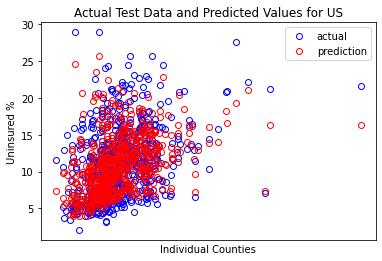

In [286]:
# Plot the actual values
plt.plot(true_data['county_name'], true_data['actual'], 'bo', label = 'actual', markerfacecolor='none')
# Plot the predicted values
plt.plot(predictions_data['county_name'], predictions_data['prediction'], 'ro', label = 'prediction',
        markerfacecolor='none')

plt.xticks([]); 
plt.legend()
# Graph labels
plt.xlabel('Individual Counties'); plt.ylabel('Uninsured %'); plt.title('Actual Test Data and Predicted Values for {}'.format('US'))
plt.savefig("Data/Random_Forest_Results/Predictions_Scatter/us_actual_predictions_scatter.png")

Source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [287]:
importances = rf.feature_importances_
importances

array([0.00216219, 0.00978388, 0.00232214, 0.00743284, 0.00553511,
       0.0039961 , 0.01011335, 0.00485965, 0.0143723 , 0.00615559,
       0.06064131, 0.0049297 , 0.00365843, 0.00854744, 0.0023908 ,
       0.00273351, 0.00803517, 0.00349705, 0.01264618, 0.03713471,
       0.00503614, 0.01042272, 0.00286323, 0.01536126, 0.03804474,
       0.01063564, 0.00827531, 0.00288367, 0.00262261, 0.0033196 ,
       0.00395407, 0.0039624 , 0.00610392, 0.00360646, 0.0118509 ,
       0.00043848, 0.0030839 , 0.00462365, 0.01890484, 0.00403125,
       0.01165331, 0.00485201, 0.00294503, 0.00278132, 0.00323936,
       0.00255365, 0.00368157, 0.00286537, 0.00861411, 0.00310437,
       0.06069081, 0.03012313, 0.00227192, 0.00222411, 0.0058378 ,
       0.00330631, 0.00355505, 0.07426342, 0.00305827, 0.00391675,
       0.00307939, 0.0106279 , 0.00738084, 0.00619812, 0.01780258,
       0.04170924, 0.00717676, 0.00353685, 0.03128806, 0.21084318,
       0.04181719, 0.00402368, 0.00800632])

In [288]:
features_list.remove('name')

In [289]:
forest_importances = pd.Series(importances, index=features_list)
forest_importances = forest_importances.sort_values(ascending=False).head(10)
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances

%_non_hispanic_white                                 0.210843
children_eligible_for_free_or_reduced_price_lunch    0.074263
motor_vehicle_crash_deaths                           0.060691
excessive_drinking                                   0.060641
%_not_proficient_in_english                          0.041817
%_american_indian_and_alaskan_native                 0.041709
some_college                                         0.038045
ratio_of_population_to_mental_health_providers       0.037135
%_hispanic                                           0.031288
insufficient_sleep                                   0.030123
dtype: float64

<ipython-input-290-ac285af466c6>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


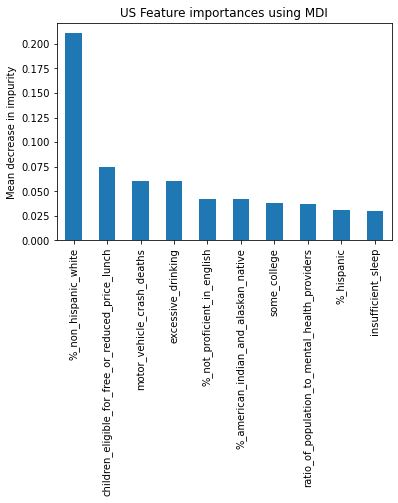

In [290]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("US Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('Data/Random_Forest_Results/Feature_Importance/us_feature_importance_bar.png')

In [291]:
most_important_col = forest_importances[forest_importances == forest_importances.max()].index.to_list()[0]
top_10_col = forest_importances.index.to_list() + ['uninsured']


In [292]:
analysis_features = features_df.drop(columns = ['state_fips_code','state_abbreviation', 'name'])
analysis_features_list = features_df.drop(columns = ['state_fips_code','state_abbreviation']).columns.to_list()
analysis_features = imp.fit_transform(analysis_features)

name = analysis_features[:, analysis_features_list.index('name')]

analysis_features_list.remove('name')

analysis_data = pd.DataFrame(analysis_features, index=name, columns = analysis_features_list )

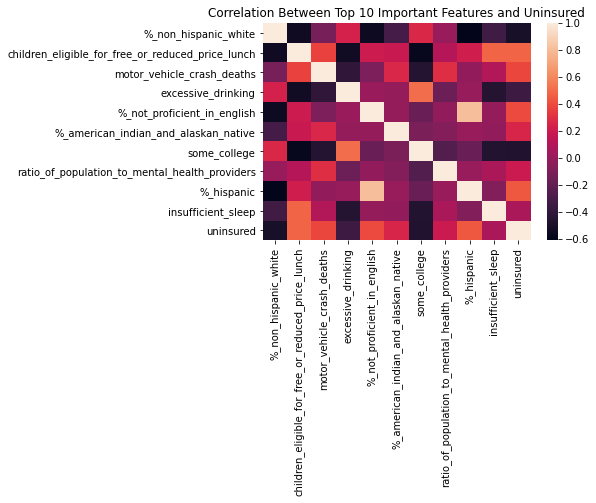

In [293]:
# Look at correlation between top ten features and uninsured
corr = analysis_data[top_10_col].corr()
plt.title("Correlation Between Top 10 Important Features and Uninsured")
sns.heatmap(corr.loc[top_10_col])
plt.show()
plt.close()

In [294]:
def low_high(rate):
    maximum = analysis_data[most_important_col].max()
    minimum = analysis_data[most_important_col].min()
    rang = maximum-minimum
    if rate < (minimum + rang/2):
        return 'low'
    else:
        return 'high'
    
analysis_data['level'] = analysis_data[most_important_col].apply(low_high)

In [295]:
signif_df = analysis_data.set_index('level')

In [297]:
col_list = []
for column in signif_df.columns:
    if column != most_important_col:
        stats = pg.ttest(signif_df.loc['low'][column], signif_df.loc['high'][column])
        if stats['p-val'][0] <= 0.05:
            print("Column: {}, p-value: {}".format(column, stats['p-val'][0]))
            col_list.append(column)
    

Column: premature_death, p-value: 1.5697672406628686e-14
Column: poor_or_fair_health, p-value: 7.370176648473401e-76
Column: poor_physical_health_days, p-value: 2.532640617197001e-31
Column: poor_mental_health_days, p-value: 8.191965447047007e-08
Column: low_birthweight, p-value: 5.950954995621717e-34
Column: adult_smoking, p-value: 7.312111002589552e-07
Column: adult_obesity, p-value: 0.014419959167734427
Column: food_environment_index, p-value: 1.3403036587539348e-29
Column: excessive_drinking, p-value: 1.9994863957665936e-23
Column: sexually_transmitted_infections, p-value: 6.237228906471313e-52
Column: teen_births, p-value: 3.5562999591541226e-44
Column: uninsured, p-value: 1.4043077468262905e-46
Column: primary_care_physicians, p-value: 0.02973035041558636
Column: ratio_of_population_to_primary_care_physicians, p-value: 0.04597715784751441
Column: mental_health_providers, p-value: 0.0018294224949970315
Column: preventable_hospital_stays, p-value: 9.228171518366144e-06
Column: mamm

In [304]:
corr = signif_df[col_list + ['uninsured']].corr()
corr.uninsured


,uninsured,uninsured
premature_death,0.293211,0.293211
poor_or_fair_health,0.450383,0.450383
poor_physical_health_days,0.272780,0.272780
poor_mental_health_days,0.139857,0.139857
low_birthweight,0.223943,0.223943
adult_smoking,0.166039,0.166039
adult_obesity,0.045481,0.045481
food_environment_index,-0.386244,-0.386244
excessive_drinking,-0.348200,-0.348200
sexually_transmitted_infections,0.237991,0.237991
